Setup Environment

In [1]:
# Import libraries and modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Set the style of the plots
sns.set_theme(style="whitegrid")


Define the constants and mappings

In [2]:
raw_data_dir = "../data/raw"
# List of Travistorrent files
input_files = [
    "travistorrent-2015.csv",
    "travistorrent-2016.csv",
    "travistorrent-2017.csv"
]

# Mapping for 2015
columns_mapping_2015 = {
    "status": "tr_status",
    "project_name": "gh_project_name",
    "is_pr": "gh_is_pr",
    "team_size": "gh_team_size",
    "num_commits": "git_num_commits",
    "num_issue_comments": "gh_num_issue_comments",
    "num_commit_comments": "gh_num_commit_comments",
    "num_pr_comments": "gh_num_pr_comments",
    "src_churn": "git_diff_src_churn",
    "test_churn": "git_diff_test_churn",
    "files_added": "gh_diff_files_added",
    "files_deleted": "gh_diff_files_deleted",
    "files_modified": "gh_diff_files_modified",
    "tests_added": "gh_diff_tests_added",
    "tests_deleted": "gh_diff_tests_deleted",
    "src_files": "gh_diff_src_files",
    "doc_files": "gh_diff_doc_files",
    "other_files": "gh_diff_other_files",
    "commits_on_files_touched": "gh_num_commits_on_files_touched",
    "sloc": "gh_sloc",
    "test_lines_per_kloc": "gh_test_lines_per_kloc",
    "test_cases_per_kloc": "gh_test_cases_per_kloc",
    "asserts_per_kloc": "gh_asserts_cases_per_kloc",
    "main_team_member": "gh_by_core_team_member",
    "started_at": "gh_build_started_at"
}

# Mapping for 2016
columns_mapping_2016 = {
    "tr_status": "tr_status",
    "gh_project_name": "gh_project_name",
    "gh_is_pr": "gh_is_pr",
    "gh_team_size": "gh_team_size",
    "git_num_commits": "git_num_commits",
    "gh_num_issue_comments": "gh_num_issue_comments",
    "gh_num_commit_comments": "gh_num_commit_comments",
    "gh_num_pr_comments": "gh_num_pr_comments",
    "gh_src_churn": "git_diff_src_churn",
    "gh_test_churn": "git_diff_test_churn",
    "gh_files_added": "gh_diff_files_added",
    "gh_files_deleted": "gh_diff_files_deleted",
    "gh_files_modified": "gh_diff_files_modified",
    "gh_tests_added": "gh_diff_tests_added",
    "gh_tests_deleted": "gh_diff_tests_deleted",
    "gh_src_files": "gh_diff_src_files",
    "gh_doc_files": "gh_diff_doc_files",
    "gh_other_files": "gh_diff_other_files",
    "gh_commits_on_files_touched": "gh_num_commits_on_files_touched",
    "gh_sloc": "gh_sloc",
    "gh_test_lines_per_kloc": "gh_test_lines_per_kloc",
    "gh_test_cases_per_kloc": "gh_test_cases_per_kloc",
    "gh_asserts_cases_per_kloc": "gh_asserts_cases_per_kloc",
    "gh_by_core_team_member": "gh_by_core_team_member",
    "tr_started_at": "gh_build_started_at",
}

columns_mapping_2017 = {
    "tr_status": "tr_status",
    "gh_project_name": "gh_project_name",
    "gh_is_pr": "gh_is_pr",
    "gh_team_size": "gh_team_size",
    "git_num_commits": "git_num_commits",
    "gh_num_issue_comments": "gh_num_issue_comments",
    "gh_num_commit_comments": "gh_num_commit_comments",
    "gh_num_pr_comments": "gh_num_pr_comments",
    "git_diff_src_churn": "git_diff_src_churn",
    "git_diff_test_churn": "git_diff_test_churn",
    "gh_diff_files_added": "gh_diff_files_added",
    "gh_diff_files_deleted": "gh_diff_files_deleted",
    "gh_diff_files_modified": "gh_diff_files_modified",
    "gh_diff_tests_added": "gh_diff_tests_added",
    "gh_diff_tests_deleted": "gh_diff_tests_deleted",
    "gh_diff_src_files": "gh_diff_src_files",
    "gh_diff_doc_files": "gh_diff_doc_files",
    "gh_diff_other_files": "gh_diff_other_files",
    "gh_num_commits_on_files_touched": "gh_num_commits_on_files_touched",
    "gh_sloc": "gh_sloc",
    "gh_test_lines_per_kloc": "gh_test_lines_per_kloc",
    "gh_test_cases_per_kloc": "gh_test_cases_per_kloc",
    "gh_asserts_cases_per_kloc": "gh_asserts_cases_per_kloc",
    "gh_by_core_team_member": "gh_by_core_team_member",
    "gh_build_started_at": "gh_build_started_at",
}

dtype_spec = {
    "git_diff_src_churn": "float32",
    "gh_diff_files_modified": "float32",
    "gh_test_lines_per_kloc": "float32"
}

Load and Combine Raw Data

In [3]:
"""Load and concatenate multiple Travistorrent CSV files"""
dataframes = []
for file in input_files:
    file_path = os.path.join(raw_data_dir, file)
    if os.path.exists(file_path):
        df_chunk = pd.read_csv(file_path, dtype=dtype_spec, low_memory=False)
        print(f"{file}: {len(df_chunk)} rows")
        if "2015" in file:
            df_chunk.rename(columns=columns_mapping_2015, inplace=True)
        elif "2016" in file:
            df_chunk.rename(columns=columns_mapping_2016, inplace=True)
        else:
            df_chunk.rename(columns=columns_mapping_2017, inplace=True)
            
        columns_to_keep = list(set(columns_mapping_2015.values()) & set(columns_mapping_2016.values()) & set(columns_mapping_2017.values()))
        available_columns = [col for col in columns_to_keep if col in df_chunk.columns]
        filtered_df = df_chunk[available_columns].copy()
        dataframes.append(filtered_df)
    else:
        print(f"File {file} not found. Skipping...")
if not dataframes:
    raise FileNotFoundError("No files found in the list")

# Load and combine data
combined_df = pd.concat(dataframes, ignore_index=True)
print(f"Combined dataset shape: {combined_df.shape}")

# Quick inspection
print("\nDataset info:")
print(combined_df.info())
print("\nFirst 5 rows:")
print(combined_df.head())

travistorrent-2015.csv: 2372655 rows
travistorrent-2016.csv: 2640825 rows
travistorrent-2017.csv: 3881992 rows


/tmp/ipykernel_179581/558692488.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dataframes, ignore_index=True)


Combined dataset shape: (8895472, 25)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8895472 entries, 0 to 8895471
Data columns (total 25 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   gh_num_commit_comments           int64  
 1   gh_diff_files_added              float64
 2   gh_diff_tests_deleted            float64
 3   gh_diff_files_modified           float64
 4   gh_team_size                     float64
 5   gh_diff_doc_files                float64
 6   gh_asserts_cases_per_kloc        float64
 7   gh_sloc                          float64
 8   gh_is_pr                         bool   
 9   git_diff_src_churn               float64
 10  git_diff_test_churn              float64
 11  gh_num_issue_comments            float64
 12  gh_diff_other_files              float64
 13  gh_diff_files_deleted            float64
 14  gh_build_started_at              object 
 15  gh_test_cases_per_kloc           float64
 16  g

Data Preprocessing

In [4]:
# Rename and convert target column 
combined_df.rename(columns={"tr_status": "build_failed"}, inplace=True)
combined_df["build_failed"] = combined_df["build_failed"].map({"passed": 0, "failed": 1, "errored": 1, "canceled": 1})

# Print missing values information and rows with missing values
missing_count = combined_df.isna().sum()
missing_ratio = (missing_count / len(combined_df)) * 100
missing_df = pd.DataFrame({'missing_count': missing_count, 'missing_ratio (%)': missing_ratio})
print(missing_df.sort_values(by='missing_count', ascending=False))
rows_with_na = combined_df[combined_df.isna().any(axis=1)]
print("Shape of rows with missing values:", rows_with_na.shape)
print(rows_with_na.head(10))

# Drop rows with missing values
columns_required = ["build_failed", "gh_project_name", "gh_build_started_at"] # Only columns can not fill with default values
before_drop = len(combined_df)
combined_df.dropna(subset=columns_required, inplace=True)
print(f"\nDropped {before_drop - len(combined_df)} rows missing critical columns. New shape: {combined_df.shape}")

# Drop duplicates
num_duplicates = combined_df.duplicated().sum()
print(f"\nNumber of duplicates: {num_duplicates}")
initial_rows = len(combined_df)
combined_df.drop_duplicates(inplace=True)
print(f"\nDropped {initial_rows - len(combined_df)} duplicates. New shape: {combined_df.shape}")

# Check if DataFrame is empty after duplicates
if combined_df.empty:
    raise ValueError("DataFrame is empty after dropping duplicates. Check duplicate criteria or data quality.")

# Encode categorical columns
categorical_columns = ["gh_is_pr", "gh_by_core_team_member"]
label_encoders = {}
for col in categorical_columns:
    if col in combined_df.columns:
        le = LabelEncoder()
        combined_df[col] = le.fit_transform(combined_df[col].astype(str))
        label_encoders[col] = le
    else:
        print(f"Column {col} not found in the dataset. Skipping...")

# Normalize numerical columns
numerical_columns = [
    "git_num_commits",
    "gh_num_commit_comments",
    "git_diff_src_churn",
    "git_diff_test_churn",
    "gh_diff_files_added",
    "gh_diff_files_deleted",
    "gh_diff_files_modified",
    "gh_diff_tests_added",
    "gh_diff_tests_deleted",
    "gh_diff_src_files",
    "gh_diff_doc_files",
    "gh_diff_other_files",
    "gh_num_commits_on_files_touched",
    "gh_sloc",
    "gh_test_lines_per_kloc",
    "gh_test_cases_per_kloc",
    "gh_asserts_cases_per_kloc",
    "gh_team_size",
    "gh_num_issue_comments",
    "gh_num_pr_comments"
]
scaler = MinMaxScaler()
combined_df[numerical_columns] = scaler.fit_transform(combined_df[numerical_columns].fillna(0))
print("\nDataset after encoding and normalization:")
print(combined_df.head())
print(f"Final shape: {combined_df.shape}")

                                 missing_count  missing_ratio (%)
git_num_commits                        3881992          43.640090
gh_num_issue_comments                  3061250          34.413576
gh_num_pr_comments                     3061250          34.413576
gh_diff_doc_files                      2372655          26.672615
gh_team_size                           2372655          26.672615
gh_sloc                                2372655          26.672615
gh_diff_tests_deleted                  2372655          26.672615
gh_diff_files_modified                 2372655          26.672615
gh_diff_files_added                    2372655          26.672615
gh_num_commits_on_files_touched        2372655          26.672615
gh_diff_tests_added                    2372655          26.672615
gh_asserts_cases_per_kloc              2372655          26.672615
git_diff_src_churn                     2372655          26.672615
gh_diff_files_deleted                  2372655          26.672615
gh_test_ca

Print imbalance information

Class distribution:
build_failed
0.0    0.729685
1.0    0.270315
Name: proportion, dtype: float64


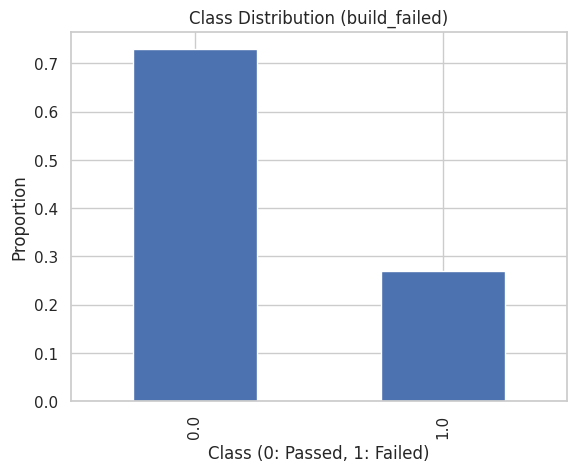

In [5]:
imbalance = combined_df['build_failed'].value_counts(normalize=True)
print("Class distribution:")
print(imbalance)

# Plot class distribution
imbalance.plot(kind='bar', title='Class Distribution (build_failed)')
plt.xlabel('Class (0: Passed, 1: Failed)')
plt.ylabel('Proportion')
plt.show()

Print top 20 projects by number of rows

Top 20 Projects by Number of Rows:
gh_project_name
apache/jackrabbit-oak               19680
ros/rosdistro                       17167
opf/openproject                     17046
apache/sling                        15401
jruby/jruby                         13217
CartoDB/cartodb                     12231
getsentry/sentry                    11727
CloudifySource/cloudify             11422
Graylog2/graylog2-server            10376
cloudfoundry/cloud_controller_ng     8800
ets-berkeley-edu/calcentral          8431
rg3/youtube-dl                       8269
cloudfoundry/bosh                    8160
gradle/gradle                        7406
orbeon/orbeon-forms                  7372
spree/spree                          7099
sharetribe/sharetribe                6967
opal/opal                            6824
projecthydra/sufia                   6236
bbatsov/rubocop                      6150
Name: count, dtype: int64


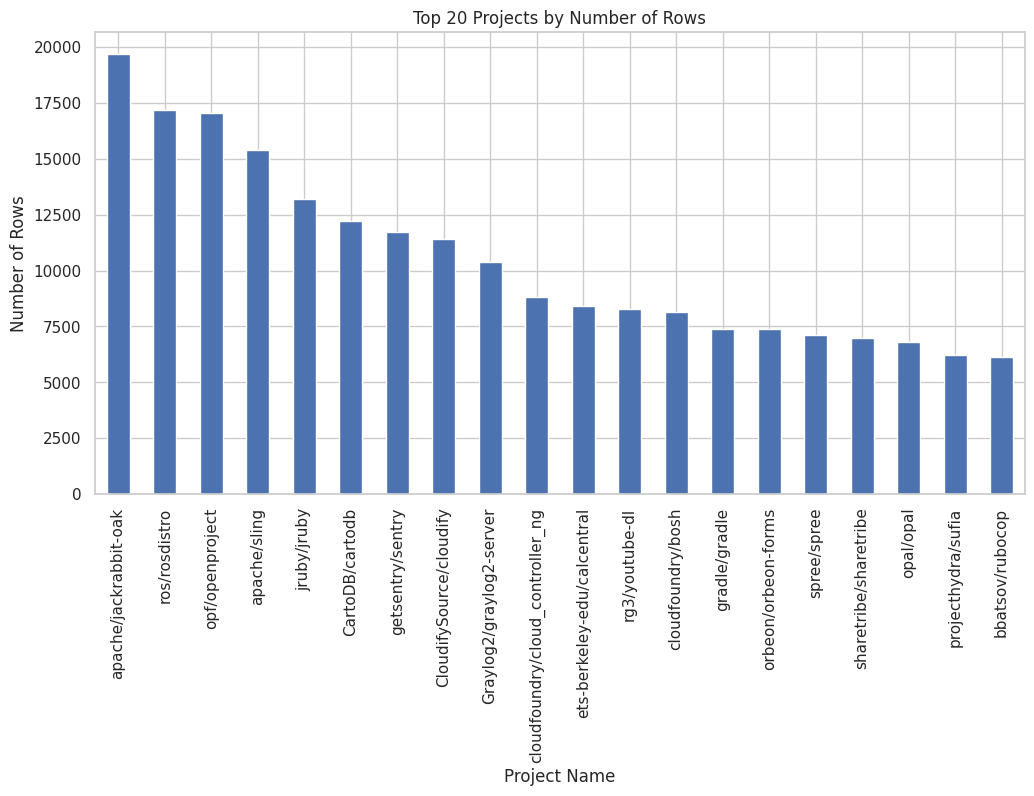

In [6]:
project_counts = combined_df['gh_project_name'].value_counts().head(20)
print("Top 20 Projects by Number of Rows:")
print(project_counts)

# Plot top 20 projects by number of rows
project_counts.plot(kind='bar', figsize=(12, 6), title='Top 20 Projects by Number of Rows')
plt.xlabel('Project Name')
plt.ylabel('Number of Rows')
plt.xticks(rotation=90)
plt.show()

Print balance degree and class distribution

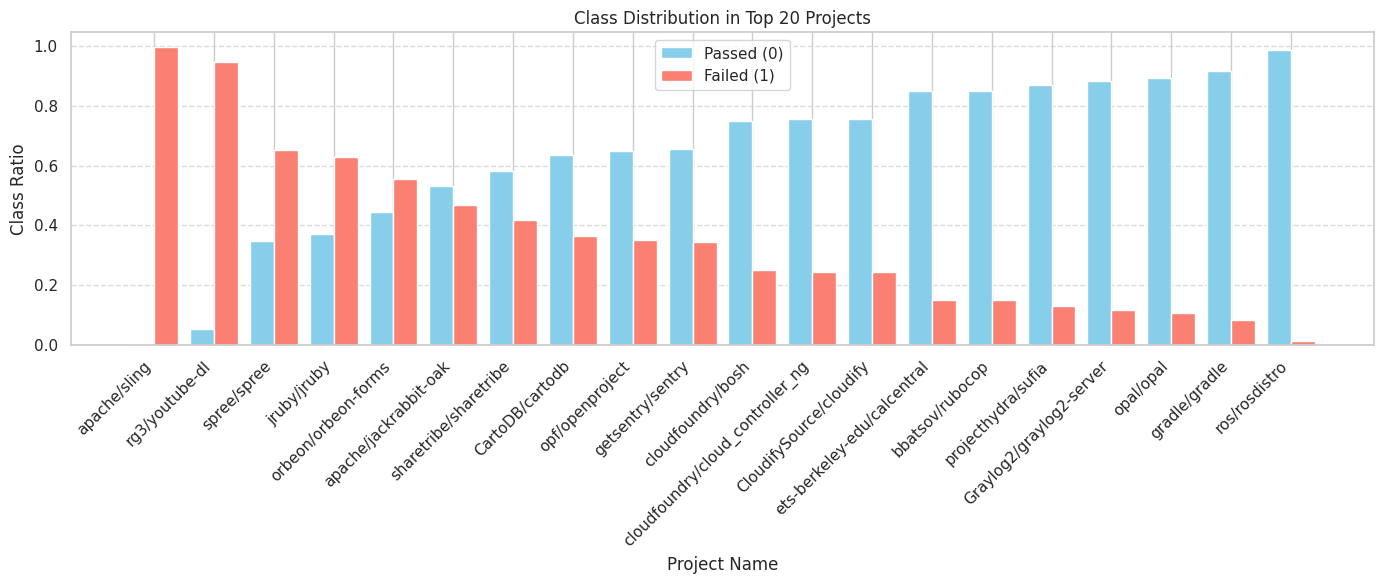

                             project  failed_ratio  passed_ratio  total_rows
0              apache/jackrabbit-oak      0.467327      0.532673       19680
1                      ros/rosdistro      0.013514      0.986486       17167
2                    opf/openproject      0.352634      0.647366       17046
3                       apache/sling      0.994546      0.005454       15401
4                        jruby/jruby      0.627298      0.372702       13217
5                    CartoDB/cartodb      0.365547      0.634453       12231
6                   getsentry/sentry      0.344248      0.655752       11727
7            CloudifySource/cloudify      0.243740      0.756260       11422
8           Graylog2/graylog2-server      0.118639      0.881361       10376
9   cloudfoundry/cloud_controller_ng      0.245341      0.754659        8800
10       ets-berkeley-edu/calcentral      0.153007      0.846993        8431
11                    rg3/youtube-dl      0.946426      0.053574        8269

In [7]:
# Calculate class distribution for each project
balance_data = []
for project in project_counts.index:
    project_df = combined_df[combined_df['gh_project_name'] == project]
    class_counts = project_df['build_failed'].value_counts(normalize=True)
    failed_ratio = class_counts.get(1.0, 0.0)
    passed_ratio = class_counts.get(0.0, 0.0)
    balance_data.append({
        'project': project,
        'failed_ratio': failed_ratio,
        'passed_ratio': passed_ratio,
        'total_rows': len(project_df)
    })

# Create DataFrame and sort by failed ratio
balance_df = pd.DataFrame(balance_data)
balance_df = balance_df.sort_values(by='failed_ratio', ascending=False)

# Plot class distribution for top 20 projects
plt.figure(figsize=(14, 6))
bar_width = 0.4
x = np.arange(len(balance_df))

plt.bar(x - bar_width/2, balance_df['passed_ratio'], width=bar_width, label='Passed (0)', color='skyblue')
plt.bar(x + bar_width/2, balance_df['failed_ratio'], width=bar_width, label='Failed (1)', color='salmon')

plt.xticks(ticks=x, labels=balance_df['project'], rotation=45, ha='right')
plt.xlabel('Project Name')
plt.ylabel('Class Ratio')
plt.title('Class Distribution in Top 20 Projects')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print class distribution for top 20 projects
print(balance_df[['project', 'failed_ratio', 'passed_ratio', 'total_rows']].sort_index())


Save data by project

In [8]:
output_data_dir = "../data/processed"

top_projects = project_counts.index
for project in top_projects:
    project_df = combined_df[combined_df['gh_project_name'] == project]
    file_name = project.replace("/", "_").replace(":", "_").replace(" ", "_") + ".csv"
    project_df.to_csv(os.path.join(output_data_dir, file_name), index=False)
    print(f"Saved {file_name} with {len(project_df)} rows")

Saved apache_jackrabbit-oak.csv with 19680 rows
Saved ros_rosdistro.csv with 17167 rows
Saved opf_openproject.csv with 17046 rows
Saved apache_sling.csv with 15401 rows
Saved jruby_jruby.csv with 13217 rows
Saved CartoDB_cartodb.csv with 12231 rows
Saved getsentry_sentry.csv with 11727 rows
Saved CloudifySource_cloudify.csv with 11422 rows
Saved Graylog2_graylog2-server.csv with 10376 rows
Saved cloudfoundry_cloud_controller_ng.csv with 8800 rows
Saved ets-berkeley-edu_calcentral.csv with 8431 rows
Saved rg3_youtube-dl.csv with 8269 rows
Saved cloudfoundry_bosh.csv with 8160 rows
Saved gradle_gradle.csv with 7406 rows
Saved orbeon_orbeon-forms.csv with 7372 rows
Saved spree_spree.csv with 7099 rows
Saved sharetribe_sharetribe.csv with 6967 rows
Saved opal_opal.csv with 6824 rows
Saved projecthydra_sufia.csv with 6236 rows
Saved bbatsov_rubocop.csv with 6150 rows
